# Feature Ranking with Recursive Feature Elimination

Feature selection is the process of selecting the optimal number of features for your machine learning model. This is very critical especially when you have many feaures. We have seen how to do this previously using feature importance, in this part we'll see how to do the same using feature ranking. 

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('heart.csv')

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


# Data Splitting

In [5]:
X = df.drop(['target'],axis=1)
y = df['target']

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

# Package Imports

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

# Recursive Feature Elimination

In [8]:
rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=5)
# The estimator should return some coefficients for example a linear model or feature impotances
# like the random forest classifier

In [9]:
model = GradientBoostingClassifier()

# Create a Pipeline

We perform cross validation in a pipeline in order to avoid any data leakage. The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters. A Pipeline also enables you to perform a couple of steps in a sequential manner, eg data pre-processing and feature selection.

You will call the fit method to your data set once and all these steps will be applied.

In [10]:
pipe = Pipeline([('Feature Selection', rfe), ('Model', model)])


# RepeatedStratifiedKFold

Repeats Stratified K-Fold n times with different randomization in each repetition.

The stratified K fold ensures that the number of samples from each class is well balanced in each fold

RepeatedStratifiedKFold repeats the stratified K fold the specified number of times, with a different randomization in each repetition.

In [11]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=0)
n_scores = cross_val_score(pipe, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.7594466403162055

In [12]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('Feature Selection',
                 RFE(estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                          criterion='friedman_mse',
                                                          init=None,
                                                          learning_rate=0.1,
                                                          loss='deviance',
                                                          max_depth=3,
                                                          max_features=None,
                                                          max_leaf_nodes=None,
                                                          min_impurity_decrease=0.0,
                                                          min_impurity_split=None,
                                                          min_samples_leaf=1,
                                                          min_samples_split=2,
          

# Support 

The support indicates whether or not a feature was chosen.

In [13]:
rfe.support_

array([ True, False,  True, False, False, False, False, False, False,
        True, False,  True,  True])

In [14]:
pd.DataFrame(rfe.support_,index=X.columns,columns=['Rank']).head()

,Rank
age,True
sex,False
cp,True
trestbps,False
chol,False


In [15]:
X.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

# Feature Ranks

Selected features are assigned rank 1

In [16]:
rfe.ranking_

array([1, 7, 1, 5, 2, 9, 8, 6, 3, 1, 4, 1, 1])

In [17]:
rf_df = pd.DataFrame(rfe.ranking_,index=X.columns,columns=['Rank']).sort_values(by='Rank',ascending=True)

In [18]:
rf_df

,Rank
age,1
cp,1
oldpeak,1
ca,1
thal,1
chol,2
exang,3
slope,4
trestbps,5
thalach,6


In [19]:
pipe.score(X_test, y_test)

0.7763157894736842

In [20]:
predictions = pipe.predict(X_test)

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

In [22]:
confusion_matrix(y_test, predictions)

array([[26,  9],
       [ 8, 33]])

In [23]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.76      0.74      0.75        35
           1       0.79      0.80      0.80        41

    accuracy                           0.78        76
   macro avg       0.78      0.77      0.77        76
weighted avg       0.78      0.78      0.78        76



# Automatic Feature Selection

We can also automatically select the most optimal feautures using recursive feature elimination and cross-validation

In [24]:
from sklearn.feature_selection import RFECV

In [25]:
rfecv = RFECV(estimator=GradientBoostingClassifier())

# Make the Pipeline

In [26]:
pipeline = Pipeline([('Feature Selection', rfecv), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=0)
n_scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.782490118577075

In [27]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('Feature Selection',
                 RFECV(cv=None,
                       estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                            criterion='friedman_mse',
                                                            init=None,
                                                            learning_rate=0.1,
                                                            loss='deviance',
                                                            max_depth=3,
                                                            max_features=None,
                                                            max_leaf_nodes=None,
                                                            min_impurity_decrease=0.0,
                                                            min_impurity_split=None,
                                                            min_samples_leaf=1,
                                   

# Optimal number of features

In [28]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 6


# Support

In [29]:
rfecv.support_

array([ True, False,  True, False,  True, False, False, False, False,
        True, False,  True,  True])

# Feature Ranking

In [30]:
rfecv.ranking_

array([1, 6, 1, 4, 1, 8, 7, 5, 2, 1, 3, 1, 1])

In [31]:
rfecv_df = pd.DataFrame(rfecv.ranking_,index=X.columns,columns=['Rank']).sort_values(by='Rank',ascending=True)
rfecv_df

,Rank
age,1
cp,1
chol,1
oldpeak,1
ca,1
thal,1
exang,2
slope,3
trestbps,4
thalach,5


# Grid Scores

These are the scores obtained from cross-validation

In [32]:
rfecv.grid_scores_

array([0.70512077, 0.70019324, 0.71371981, 0.74454106, 0.77980676,
       0.78      , 0.77111111, 0.77990338, 0.76222222, 0.77082126,
       0.77961353, 0.77516908, 0.77082126])

# Plot the Grid Scores

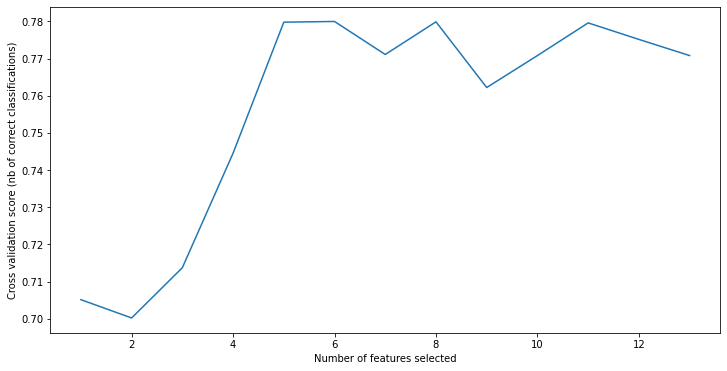

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Happy Learning!